# Analysis

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [42]:
df = pd.read_pickle('../data/processed/proecessed.pkl.gz')

df

,ID,MRI_ID,visit,delay,sex,hand,age,YOE,SES,MMSE,CDR,eTIV,nWBV,ASF,CDR_rating,MMSE_labels,dementia
0,1,1_MR1,1,0,1,1,87,14,2.0,27.0,none,1987.0,0.696,0.883,0,None,0
1,2,2_MR1,1,0,1,1,75,12,2.0,23.0,very mild,1678.0,0.736,1.046,1,Mild,1
2,4,4_MR1,1,0,0,1,88,18,3.0,28.0,none,1215.0,0.710,1.444,0,None,0
3,5,5_MR1,1,0,1,1,80,12,4.0,28.0,none,1689.0,0.712,1.039,0,None,0
4,7,7_MR1,1,0,1,1,71,16,2.0,28.0,very mild,1357.0,0.748,1.293,1,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,36,36_MR5,5,2369,0,1,75,13,4.0,29.0,none,1349.0,0.778,1.301,0,None,0
369,48,48_MR5,5,1233,1,1,69,16,1.0,4.0,mild,1701.0,0.676,1.032,2,Severe,1
370,70,70_MR5,5,2386,1,1,86,17,1.0,30.0,none,1720.0,0.705,1.020,0,None,0
371,73,73_MR5,5,2517,0,1,77,14,3.0,29.0,none,1504.0,0.769,1.167,0,None,0


## Task-1 - Destinguishing Healthy Patient Records from ones With Dementia

### SVM

In [43]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

### Remove unusable columns from DataFrame

In [44]:

svm_df = df.drop(['MMSE_labels','CDR', 'MRI_ID','ID',], axis=1)


X = svm_df.loc[:, svm_df.columns != 'dementia']

y = svm_df['dementia']


### Split dataset into training and testing split and scale X train split

In [45]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Perform Grid Search to find optimum hyperparameters for SVC

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm_md = SVC()

param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale', 'auto', 0.1, 1, 10],
              'degree': [2, 3, 4]}

grid_search = GridSearchCV(svm_md, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


### Get report on model performance

In [47]:
svm_md = SVC(**best_params)
#Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
svm_md.fit(X_train,y_train)

y_pred = svm_md.predict(X_test)
y_train_pred = svm_md.predict(X_train)

report = metrics.classification_report(y_test,y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

test_accuracy = metrics.accuracy_score(y_test, y_pred)
training_accuracy = metrics.accuracy_score(y_train, y_train_pred)

print(f'Testing accuracy: {test_accuracy * 100}%')
print(f'Training accuracy: {training_accuracy * 100}%')
print(f'Accuracy: {accuracy * 100}%')

print(report)

Testing accuracy: 100.0%
Training accuracy: 100.0%
Accuracy: 100.0%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        34

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



### View model coeeficients to see which column is altering the model the most

In [48]:
svm_md = SVC(**best_params)
#Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
svm_md.fit(X_train,y_train)

y_pred = svm_md.predict(X_test)

y_pred = svm_md.predict(X_test)
y_train_pred = svm_md.predict(X_train)

print(svm_df.drop(['dementia'], axis=1).columns)

x = pd.DataFrame(svm_md.coef_, columns=svm_df.drop(['dementia'], axis=1).columns).T
x

Index(['visit', 'delay', 'sex', 'hand', 'age', 'YOE', 'SES', 'MMSE', 'eTIV',
       'nWBV', 'ASF', 'CDR_rating'],
      dtype='object')


,0
visit,-0.000125
delay,0.000117
sex,0.000036
hand,0.000000
age,-0.000019
YOE,-0.000088
SES,-0.000070
MMSE,-0.000180
eTIV,-0.000086
nWBV,-0.000063


### Remove column from dataframe (along with any useless columns with no coefficient) and repeat steps

In [49]:
svm_df = df.drop(['MMSE_labels','CDR', 'MRI_ID','ID','CDR_rating','hand'], axis=1)

X = svm_df.loc[:, svm_df.columns != 'dementia']

y = svm_df['dementia']

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm_md = SVC()

param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale', 'auto', 0.1, 1, 10],
              'degree': [2, 3, 4]}

grid_search = GridSearchCV(svm_md, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

svm_md = SVC(**best_params)
#Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


""" svm_md = SVC(C=1,degree=2,gamma='scale',kernel='linear') """

svm_md.fit(X_train,y_train)

y_pred = svm_md.predict(X_test)
y_train_pred = svm_md.predict(X_train)

report = metrics.classification_report(y_test,y_pred)
test_accuracy = metrics.accuracy_score(y_test, y_pred)
training_accuracy = metrics.accuracy_score(y_train, y_train_pred)

print(f'Testing accuracy: {test_accuracy}')
print(f'Training accuracy: {training_accuracy}')

print(report)

print(pd.DataFrame(svm_md.coef_, columns=svm_df.drop(['dementia'], axis=1).columns).T)

Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Testing accuracy: 0.8
Training accuracy: 0.8355704697986577
              precision    recall  f1-score   support

           0       0.80      0.85      0.82        41
           1       0.81      0.74      0.77        34

    accuracy                           0.80        75
   macro avg       0.80      0.79      0.80        75
weighted avg       0.80      0.80      0.80        75

              0
visit -0.077781
delay  0.142463
sex    0.376938
age   -0.487329
YOE   -0.495410
SES   -0.296912
MMSE  -2.441368
eTIV  -0.245577
nWBV  -0.588553
ASF    0.041507


In [50]:
""" 
feature_coef = np.array(feature_coef.values)
feature_coef = feature_coef.flat
x = svm_df.drop(['dementia'],axis=1).columns
y = np.array(x)
y.reshape(1,-1)


feature_coef_plot = sns.barplot(x=x, y=feature_coef) """

" \nfeature_coef = np.array(feature_coef.values)\nfeature_coef = feature_coef.flat\nx = svm_df.drop(['dementia'],axis=1).columns\ny = np.array(x)\ny.reshape(1,-1)\n\n\nfeature_coef_plot = sns.barplot(x=x, y=feature_coef) "

### Perform kFold cross validatation for generalisation

In [51]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm_md, X, y, cv=cv, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.82666667 0.84       0.78666667 0.77027027 0.82432432]
Mean Accuracy: 0.8095855855855856


### Plot confusion matrix

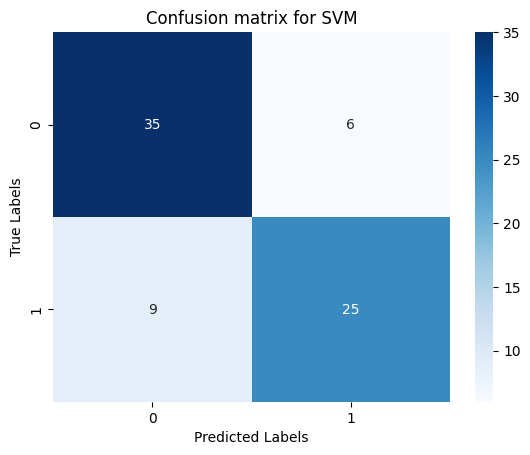

In [52]:
cm = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix_heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

confusion_matrix_heatmap.set_title('Confusion matrix for SVM')
confusion_matrix_heatmap.set_xlabel("Predicted Labels")
confusion_matrix_heatmap.set_ylabel("True Labels")

confusion_matrix_heatmap.figure.savefig('confusion_matrix_heatmap_svc.png', dpi=600)

### Plot Precion-Recall Curve

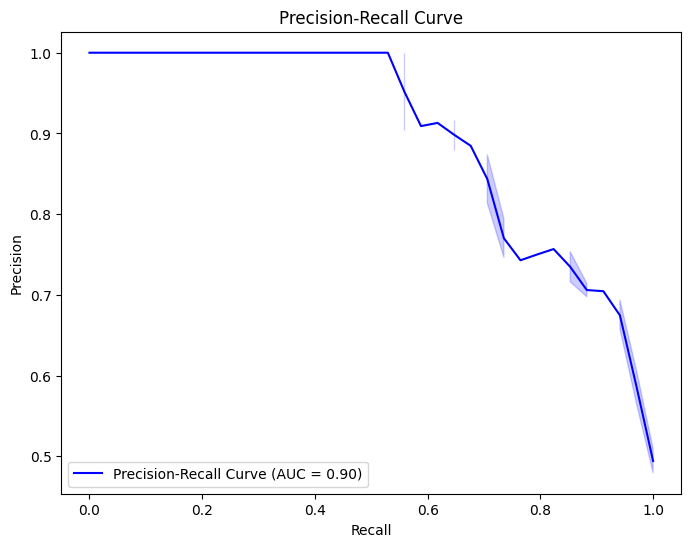

In [53]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

if hasattr(svm_md, "decision_function"):
    y_scores = svm_md.decision_function(X_test)
else:
    y_scores = svm_md.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
area = auc(recall, precision)

plt.figure(figsize=(8, 6))
auc_plot = sns.lineplot(x=recall, y=precision, label=f'Precision-Recall Curve (AUC = {area:.2f})', color='b')
auc_plot.set_xlabel('Recall')
auc_plot.set_ylabel('Precision')
auc_plot.set_title('Precision-Recall Curve')

auc_plot.figure.savefig('auc_plot_svc.png', dpi=600)

## Task 2 - Can we predict the conversion to demented status after the first visit?

In [54]:
visit_1_not_demented = df.loc[(df['visit'] == 1) & (df['CDR'] == 'none')]
visit_1_not_demented

visit_1_not_demented_ids = visit_1_not_demented['ID'].values

print(len(visit_1_not_demented_ids))

visit_n_demented = df.loc[(df['ID'].isin(visit_1_not_demented_ids)) & (df['dementia'] == 1) & (df['visit'].astype(float) > 1)]

visit_n_demented_values = visit_n_demented['ID'].values



df['develops_dementia'] = df['ID'].isin(visit_n_demented_values).astype(int)
print(visit_n_demented_values)

v1 = df[df['visit'] == 1]


85
[  5  20  54  92 103 118 127 144 145  17  20  31  41 103 127 133 176  18
 127 127]


In [55]:


v1_lgr_df = v1.drop(['MMSE_labels','CDR', 'MRI_ID','ID'], axis=1)

X = v1_lgr_df.loc[:, v1_lgr_df.columns != 'develops_dementia']

y = v1_lgr_df['develops_dementia']



In [56]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lgr_md = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization type
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations for optimization
}

grid_search = GridSearchCV(lgr_md, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

Best Parameters: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

In [58]:
#Best Parameters: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

lgr_md = LogisticRegression(**best_params)

lgr_md.fit(X_train,y_train)

y_pred = lgr_md.predict(X_test)
y_train_pred = lgr_md.predict(X_train)

report = metrics.classification_report(y_test,y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

test_accuracy = metrics.accuracy_score(y_test, y_pred)
training_accuracy = metrics.accuracy_score(y_train, y_train_pred)

print(f'Testing accuracy: {test_accuracy}')
print(f'Training accuracy: {training_accuracy}')
print(f'Accuracy: {accuracy}')

print(report)

Testing accuracy: 0.8333333333333334
Training accuracy: 0.9166666666666666
Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        25
           1       0.00      0.00      0.00         5

    accuracy                           0.83        30
   macro avg       0.42      0.50      0.45        30
weighted avg       0.69      0.83      0.76        30



c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [59]:

pd.DataFrame(lgr_md.coef_, columns=v1_lgr_df.drop(['develops_dementia'], axis=1).columns).T

print(lgr_md.coef_)

v1_lgr_df

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


,visit,delay,sex,hand,age,YOE,SES,MMSE,eTIV,nWBV,ASF,CDR_rating,dementia,develops_dementia
0,1,0,1,1,87,14,2.0,27.0,1987.0,0.696,0.883,0,0,0
1,1,0,1,1,75,12,2.0,23.0,1678.0,0.736,1.046,1,1,0
2,1,0,0,1,88,18,3.0,28.0,1215.0,0.710,1.444,0,0,0
3,1,0,1,1,80,12,4.0,28.0,1689.0,0.712,1.039,0,0,1
4,1,0,1,1,71,16,2.0,28.0,1357.0,0.748,1.293,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1,0,1,1,73,12,2.0,23.0,1661.0,0.698,1.056,1,1,0
146,1,0,0,1,66,13,2.0,30.0,1495.0,0.746,1.174,0,0,0
147,1,0,0,1,72,16,3.0,24.0,1354.0,0.733,1.296,1,1,0
148,1,0,1,1,80,16,1.0,28.0,1704.0,0.711,103.000,1,1,0


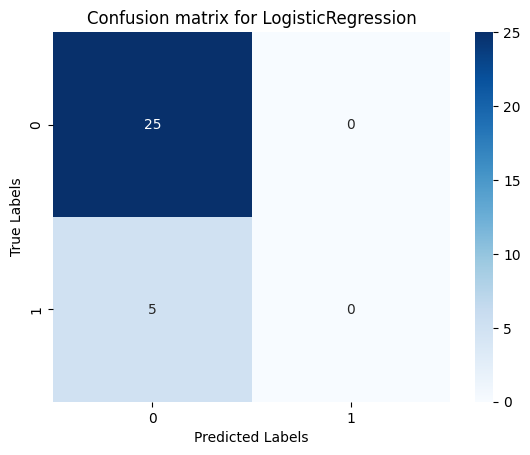

In [60]:
cm = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix_heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

confusion_matrix_heatmap.set_title('Confusion matrix for LogisticRegression')
confusion_matrix_heatmap.set_xlabel("Predicted Labels")
confusion_matrix_heatmap.set_ylabel("True Labels")

confusion_matrix_heatmap.figure.savefig('cm-heatmap-lgr.png', dpi=600)

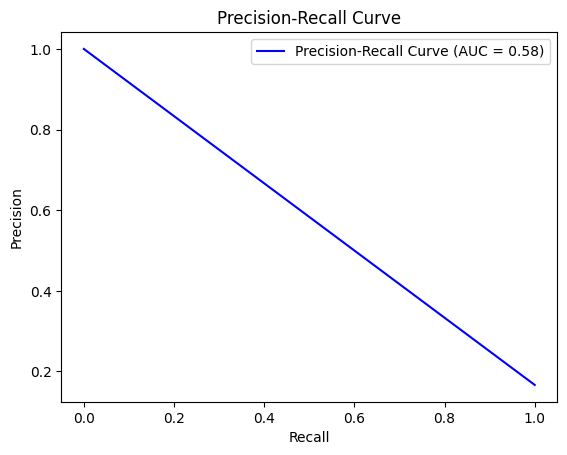

In [61]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

if hasattr(lgr_md, "decision_function"):
    y_scores = lgr_md.decision_function(X_test)
else:
    y_scores = lgr_md.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
area = auc(recall, precision)

auc_plot = sns.lineplot(x=recall, y=precision, label=f'Precision-Recall Curve (AUC = {area:.2f})', color='b')
auc_plot.set_xlabel('Recall')
auc_plot.set_ylabel('Precision')
auc_plot.set_title('Precision-Recall Curve')


auc_plot.figure.savefig('auc-lgr.png', dpi=600)


## Task 3 - what are the characteristics of patients with different dementia rating

In [62]:
df

,ID,MRI_ID,visit,delay,sex,hand,age,YOE,SES,MMSE,CDR,eTIV,nWBV,ASF,CDR_rating,MMSE_labels,dementia,develops_dementia
0,1,1_MR1,1,0,1,1,87,14,2.0,27.0,none,1987.0,0.696,0.883,0,None,0,0
1,2,2_MR1,1,0,1,1,75,12,2.0,23.0,very mild,1678.0,0.736,1.046,1,Mild,1,0
2,4,4_MR1,1,0,0,1,88,18,3.0,28.0,none,1215.0,0.710,1.444,0,None,0,0
3,5,5_MR1,1,0,1,1,80,12,4.0,28.0,none,1689.0,0.712,1.039,0,None,0,1
4,7,7_MR1,1,0,1,1,71,16,2.0,28.0,very mild,1357.0,0.748,1.293,1,None,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,36,36_MR5,5,2369,0,1,75,13,4.0,29.0,none,1349.0,0.778,1.301,0,None,0,0
369,48,48_MR5,5,1233,1,1,69,16,1.0,4.0,mild,1701.0,0.676,1.032,2,Severe,1,0
370,70,70_MR5,5,2386,1,1,86,17,1.0,30.0,none,1720.0,0.705,1.020,0,None,0,0
371,73,73_MR5,5,2517,0,1,77,14,3.0,29.0,none,1504.0,0.769,1.167,0,None,0,0


In [63]:
from sklearn.cluster import KMeans
knn_df = df.drop(['CDR', 'MRI_ID','ID','MMSE_labels'], axis=1)

scaler = StandardScaler()

X = knn_df

X = scaler.fit_transform(X)

hue=knn_df['CDR_rating']
MMSE = knn_df['MMSE']
eTIV = knn_df['eTIV']

MMSE = np.array(MMSE).reshape(-1,1)
eTIV = np.array(eTIV).reshape(-1,1)

MMSE = scaler.fit_transform(MMSE).ravel()
eTIV = scaler.fit_transform(eTIV).ravel()



In [64]:
random_state = np.random.RandomState(0)

best_score = -1
best_labels = None
best_k = 1
scores = []
k_values = []

for k in range(2,16):
    for i in range(20):
        kmeans = KMeans(k, random_state=42)
        labels = kmeans.fit(X).labels_
        score = metrics.silhouette_score(X, labels)
        scores.append(score)
        k_values.append(k)

        if score > best_score:
            best_k = k
            best_score = score
            best_labels = labels

best_score, best_labels, best_k

c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\clus

c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Temp\VS Code Projects\biomed-assignment\.venv\lib\site-packages\sklearn\clus

(0.19733761103594283,
 array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 0,

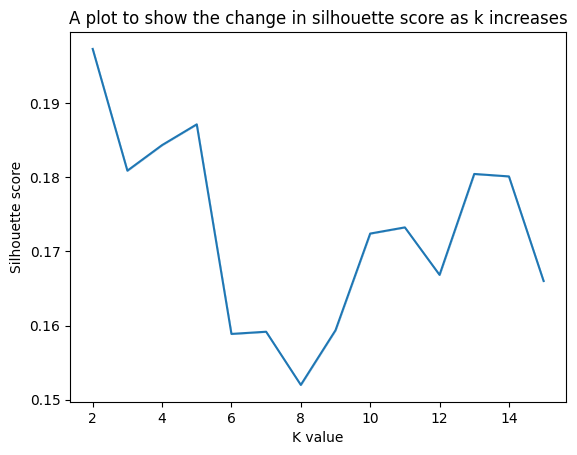

In [65]:
silhouette_k_plot = sns.lineplot(x=k_values,y=scores)
silhouette_k_plot

silhouette_k_plot.set_title('A plot to show the change in silhouette score as k increases')
silhouette_k_plot.set_xlabel('K value')
silhouette_k_plot.set_ylabel('Silhouette score')

silhouette_k_plot.figure.savefig('silhouette.png', dpi=600)


In [66]:
colors = {0:'red', 1:'green',2:'blue',3:'orange'}

X = knn_df.loc[:, knn_df.columns != 'CDR']

X = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=0, n_init='auto').fit(X)

kmeans_labels = kmeans.labels_

knn_df['cluster'] = kmeans_labels






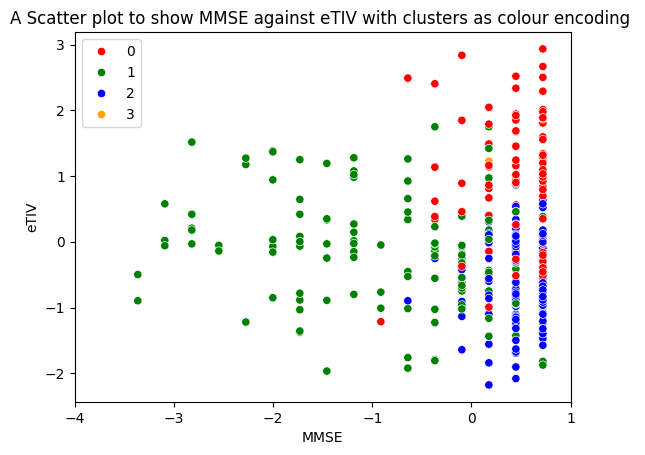

In [67]:
scatter_plot_clusters = sns.scatterplot( x=MMSE,y=eTIV, hue=kmeans_labels,palette=colors)
scatter_plot_clusters.set_xlim(-4,1)
scatter_plot_clusters.set_title('A Scatter plot to show MMSE against eTIV with clusters as colour encoding ')
scatter_plot_clusters.set_xlabel('MMSE')
scatter_plot_clusters.set_ylabel('eTIV')

scatter_plot_clusters

scatter_plot_clusters.figure.savefig('scatter_plot_clusters.png', dpi=600)

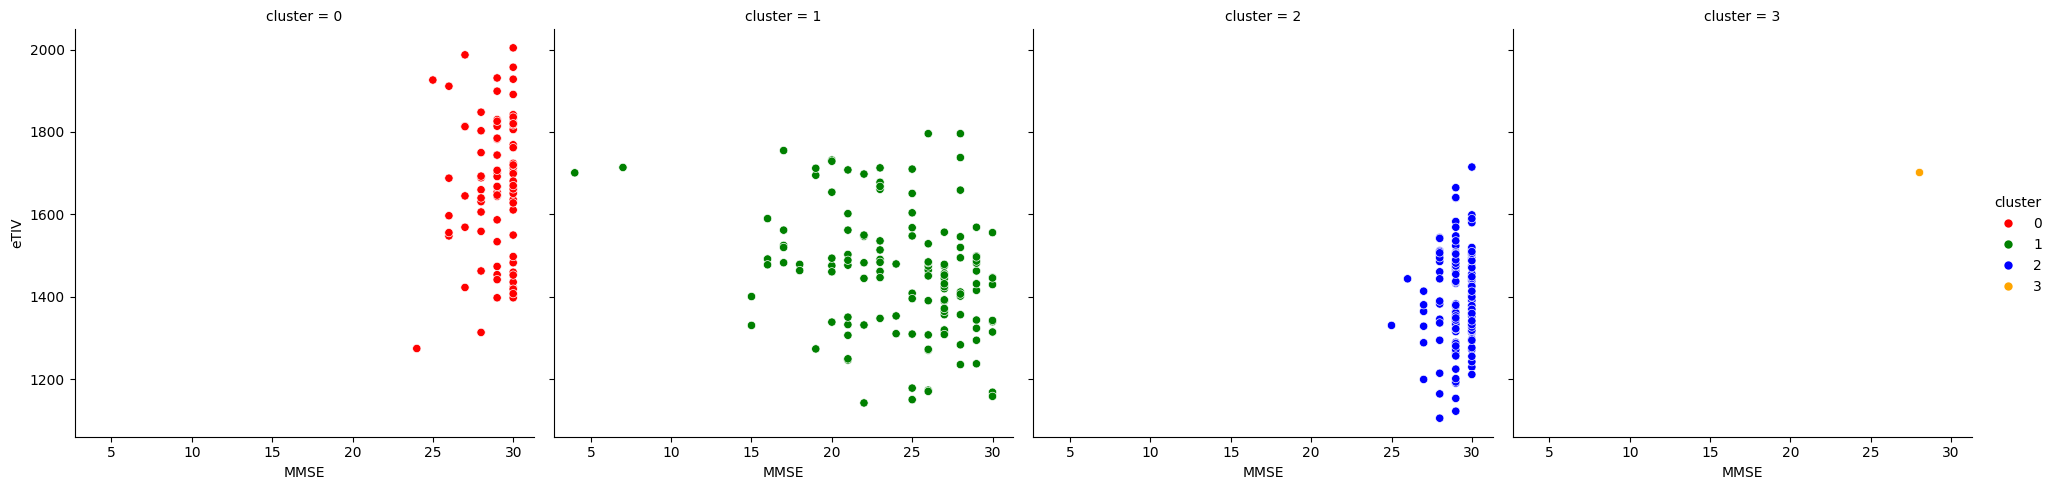

In [68]:

relplot_1 = sns.relplot(
    data=knn_df,
    x='MMSE', 
    y='eTIV',
    hue='cluster',
    col=knn_df['cluster'],
    kind='scatter',
    palette=colors,
    sizes=(10,100)
)

relplot_1.savefig('scatter_plot_clusters.png', dpi=600)

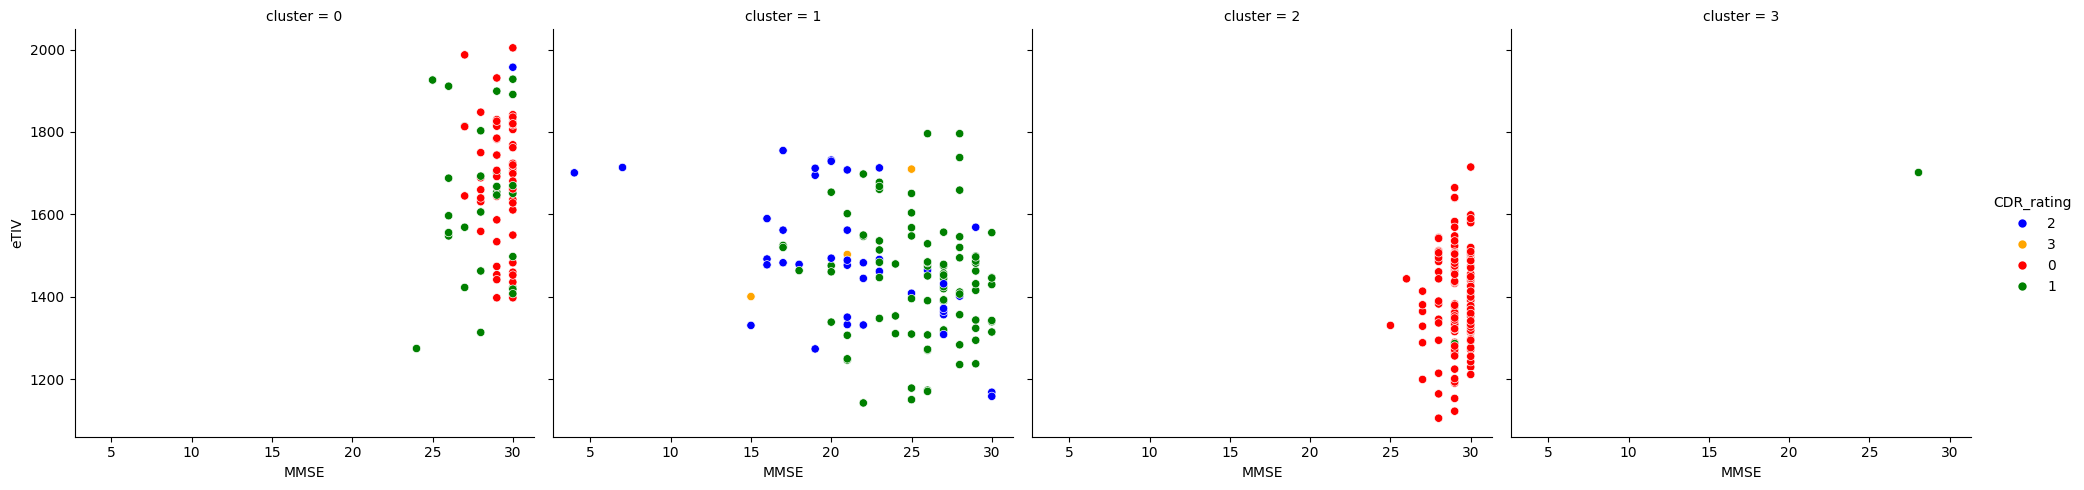

In [69]:

relplot_2 = sns.relplot(
    data=knn_df,
    x='MMSE', 
    y='eTIV',
    hue='CDR_rating',
    col=knn_df['cluster'],
    kind='scatter',
    palette=colors,
    sizes=(10,100)
)

relplot_2.savefig('scatter_plot_clusters.png', dpi=600)